## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch

## Load Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Preprocessing

In [3]:
# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Logistic Regression From Scratch

### Single Batch from Scratch

In [4]:
num_samples = X_train.shape[0]
num_classes = y_train.unique().shape[0]
batch_size = 64

# Initialize W, it should be shape (num_features, num_classes) because it will 
# transform the input (num_examples, num_features) to the output (num_examples, num_classes)
W = torch.randn(size=(X_train.shape[1], num_classes), requires_grad=True)
# Initialize b, it should be shape (1, 1) because it will be a scalar we add to each class 
# prediction for each example
b = torch.zeros(num_classes, requires_grad=True)
                
# Define softmax, which maps scalars to probabilities
def softmax(X):
    X_exp = torch.exp(X)
    return X_exp / X_exp.sum(axis=1, keepdims=True)

# Define the log-loss 
def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss

parameters = [W, b]
optimizer = SGDScratch(parameters, lr=0.1)

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

In [5]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass (training)
        O = X_batch @ W + b
        y_pred = softmax(O)
        
        # Calculate Loss
        loss = log_loss(y_pred, y_batch)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

1.7343516828214869
0.04045664500841435
0.01735090026830105


### Define Training Loop and Model

In [6]:
def accuracy(y_pred, y_true):
    label_pred = torch.argmax(y_pred, axis=1)
    accuracy = torch.sum(label_pred == y_true) / y_pred.shape[0]
    return accuracy

In [7]:
class LogisticRegressionScratch(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.W = torch.randn(size=(in_features, num_classes), requires_grad=True)
        self.b = torch.zeros(num_classes, requires_grad=True)

    def softmax(self, X):
        X_exp = torch.exp(X)
        X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
        return X_softmax

    def forward(self, X):
        O = X @ self.W + self.b
        y_pred = self.softmax(O)
        return y_pred
    
    def parameters(self):
        return [self.W, self.b]

In [8]:
class CrossEntropyScratch(nn.Module):
    def __init__(self, num_classes):
        super(CrossEntropyScratch, self).__init__()
        self.num_classes = num_classes

    def forward(self, y_pred, y_true):
        y_one_hot = nn.functional.one_hot(y_true, self.num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss

### Training the Model

In [9]:
class AccuracyScratch:
    def __init__(self):
        self.correct = 0
        self.total = 0

    def update(self, outputs, targets):
        _, predicted = torch.max(outputs, 1)
        self.correct += (predicted == targets).sum().item()
        self.total += targets.size(0)

    def compute(self):
        return self.correct / self.total if self.total else 0

    def reset(self):
        self.correct = 0
        self.total = 0

Epoch 1/15, Training Loss: 10.3002, Validation Loss: 8.1881
Validation accuracy: 0.2063
Epoch 2/15, Training Loss: 7.1381, Validation Loss: 6.2202
Validation accuracy: 0.2799
Epoch 3/15, Training Loss: 5.6343, Validation Loss: 4.9843
Validation accuracy: 0.3500
Epoch 4/15, Training Loss: 4.6237, Validation Loss: 4.1294
Validation accuracy: 0.4052
Epoch 5/15, Training Loss: 3.9128, Validation Loss: 3.5240
Validation accuracy: 0.4530
Epoch 6/15, Training Loss: 3.3982, Validation Loss: 3.0831
Validation accuracy: 0.4993
Epoch 7/15, Training Loss: 3.0159, Validation Loss: 2.7565
Validation accuracy: 0.5395
Epoch 8/15, Training Loss: 2.7281, Validation Loss: 2.5060
Validation accuracy: 0.5726
Epoch 9/15, Training Loss: 2.5018, Validation Loss: 2.3074
Validation accuracy: 0.5984
Epoch 10/15, Training Loss: 2.3186, Validation Loss: 2.1463
Validation accuracy: 0.6218
Epoch 11/15, Training Loss: 2.1677, Validation Loss: 2.0121
Validation accuracy: 0.6418
Epoch 12/15, Training Loss: 2.0390, Vali

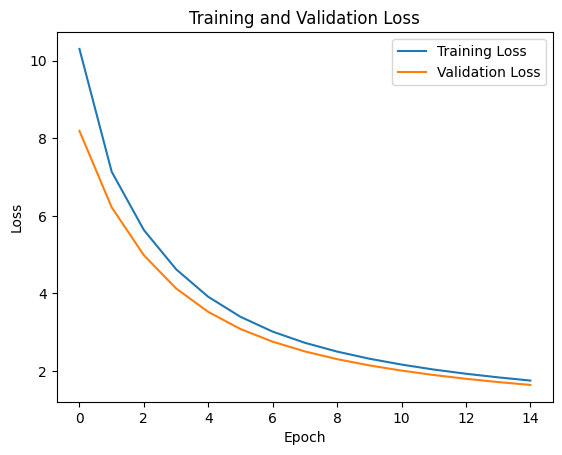

In [10]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_epochs = 15
learning_rate = 0.01

model = LogisticRegressionScratch(in_features=in_features, num_classes=num_classes)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = CrossEntropyScratch(num_classes=num_classes)
metrics = {'accuracy':AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of Logistic Regression

Epoch 1/10, Training Loss: 2.0431, Validation Loss: 1.8339
Epoch 2/10, Training Loss: 1.7859, Validation Loss: 1.7394
Epoch 3/10, Training Loss: 1.7313, Validation Loss: 1.7077
Epoch 4/10, Training Loss: 1.7075, Validation Loss: 1.6899
Epoch 5/10, Training Loss: 1.6857, Validation Loss: 1.6586
Epoch 6/10, Training Loss: 1.6577, Validation Loss: 1.6386
Epoch 7/10, Training Loss: 1.6412, Validation Loss: 1.6266
Epoch 8/10, Training Loss: 1.6305, Validation Loss: 1.6183
Epoch 9/10, Training Loss: 1.6231, Validation Loss: 1.6121
Epoch 10/10, Training Loss: 1.6174, Validation Loss: 1.6071


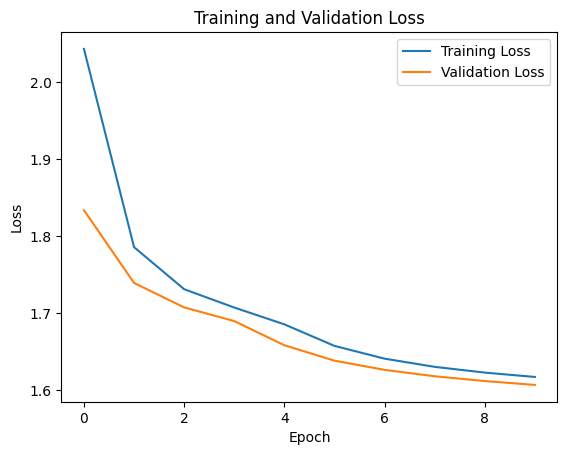

In [11]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear(x)
        out = self.softmax(out)
        return out

model = LogisticRegression(input_size=X_train.shape[1], num_classes=y_train.unique().shape[0])

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=10)